# imports

In [1]:
from sentence_transformers import SentenceTransformer, util
import torch
from transformers import RobertaTokenizer, RobertaConfig, RobertaModel

import sqlite3
import argparse
from tqdm import tqdm
import numpy as np
from matplotlib import pyplot as plt
import os
from numpy.linalg import norm
import sys
from itertools import combinations
import random
import my_utils

/home/grads/t/tiendat.ng.cs/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Utils

In [2]:
class UnionFind:
    def __init__(self):
        self.parent = {}  # Dictionary to store parent nodes
        self.ranks = {}    # Dictionary to store rank (or size) of each set
        self.processed = False
        self.project_name = None

    def find(self, x):
        if x not in self.parent:
            self.parent[x] = x
            self.ranks[x] = 1
            return x

        # Path compression
        if self.parent[x] != x:
            self.parent[x] = self.find(self.parent[x])
        return self.parent[x]

    def union(self, x, y):
        root_x = self.find(x)
        root_y = self.find(y)

        if root_x != root_y:
            if self.ranks[root_x] < self.ranks[root_y]:
                self.parent[root_x] = root_y
                self.ranks[root_y] += self.ranks[root_x]
            else:
                self.parent[root_y] = root_x
                self.ranks[root_x] += self.ranks[root_y]
            
    def process_project(self, conn, project_name):
        cursor = conn.cursor()
        self.project_name = project_name
        print("Processing", project_name)
        cursor.execute(f"SELECT * FROM {project_name}")
        for row in cursor.fetchall():
            dup_id = int(row[column_names.index("dup_id")])
            if dup_id == -1: continue
            bug_id = int(row[column_names.index("bug_id")])
            assert(dup_id != bug_id)
            self.union(bug_id, dup_id)
        self.processed = True
            
    def get_roots(self,):
        assert(self.processed)
        return list(set(self.parent.values()))
    
    def get_children(self, parent):
        assert(self.processed)
        parent = self.find(parent)
        children = [key for key, value in self.parent.items() if value == parent]
        return children
    
    def get_all_children(self, ):
        return [key for key, value in self.parent.items()]
    
    def are_dups(this, bug_id1, bug_id2):
        if (bug_id1 not in this.parent.keys() or bug_id2 not in this.parent.keys()):
            return False
        return this.parent[bug_id1] == this.parent[bug_id2]
            

In [3]:
def get_bug_ids(conn, table_name):
    cursor = conn.cursor()
    column_name = "bug_id"

    # Fetch table names using SQL query
    cursor.execute(f"SELECT DISTINCT {column_name} FROM {table_name} ORDER BY {column_name};")
    distinct_values_sorted = cursor.fetchall()

    # Extract table names from the result
    return [value[0] for value in distinct_values_sorted]

In [4]:
def get_column_names(conn, table_name):
    cursor = conn.cursor()

    # Execute a query to get information about the columns in the specified table
    cursor.execute(f"PRAGMA table_info({table_name});")
    columns_info = cursor.fetchall()

    # Extract and return the column names
    column_names = [column[1] for column in columns_info]
    return column_names

In [5]:
def get_code_feature(conn, project_name, bug_id):
    cursor = conn.cursor()

    # Fetch table names using SQL query
    query = f"SELECT * FROM {project_name} WHERE bug_id = {bug_id};"
    # print(query)
    cursor.execute(query)
    result = cursor.fetchall()[0]
    return result[column_names.index("code_feature")]

In [6]:
def get_descriptions(conn, project_name, bug_id):
    cursor = conn.cursor()

    # Fetch table names using SQL query
    query = f"SELECT * FROM {project_name} WHERE bug_id = {bug_id};"
    # print(query)
    cursor.execute(query)
    result = cursor.fetchall()[0]
    desc = result[column_names.index("description")]
    short_desc = result[column_names.index("short_desc")]

    # Extract table names from the result
    return (desc + " \n " + short_desc).replace("\\'", "'")

In [7]:
def vectorize(description, stride_len, chunk_size):
    tokens = tokenizer.tokenize(description)
    # if len og token array is < 32, we do nothing as there is not enough information
    if (len(tokens) < chunk_size // 2): return None

    # remember to add cls and sep token at each chunk
    token_ids = tokenizer.convert_tokens_to_ids([tokenizer.cls_token]+tokens+[tokenizer.sep_token])

    # divide token ids into batche of chunks
    chunk_list=[]
    for i in range(0, len(token_ids), stride_len):
        chunk = token_ids[i:min(i+chunk_size, len(token_ids))]
        assert(len(chunk) <= chunk_size)
        if len(chunk) < chunk_size:
            # keep going
            continue
            # if (len(chunk) < chunk_size // 2): continue
            # pad_length = chunk_size - len(chunk)
            # chunk += [tokenizer.pad_token_id]*pad_length
        assert(len(chunk) == chunk_size)
        # print(chunk)
        chunk_list.append(chunk)

    if(len(chunk_list) == 0): return None
    chunk_arr = np.array(chunk_list)
    # print("Chunk arr size{}".format(chunk_arr.shape))
    # context_embedding = model(torch.tensor(token_ids[:512])[None, :])[0]
    context_embedding = model(torch.tensor(chunk_arr)[:, :])[0]
    return context_embedding.detach().numpy()

In [8]:
def get_duplicated_pairs(union_find):
    roots = union_find.get_roots()
    pairs = []
    for root in roots:
        group = union_find.get_children(root)
        pairs += list(combinations(group, 2))
    return pairs

In [9]:
def get_non_duplicated_pairs(union_find, conn, size):
    from_dup = union_find.get_all_children()
    #sample in some other single reports
    assert(union_find.processed)
    samples = random.sample(get_bug_ids(conn, union_find.project_name), len(from_dup))
    
    pairs = []
    count = 0
    while (count < size):
        pair = random.sample(samples, 2)
        if pair[0] == pair[1] or union_find.are_dups(pair[0], pair[1]):
            continue
        pairs += [(pair[0], pair[1]),]
        count += 1
    return pairs

In [10]:
def get_mislabels(union_find, bug_ids, anchor_bug_id, threshold):
    assert(threshold >= 0 and threshold <= 1)
    ret = []
    for bug_id in tqdm(bug_ids):
        if not union_find.are_dups(anchor_bug_id, bug_id):
            sim_score = get_similarity_of_pair((anchor_bug_id, bug_id),)
            if sim_score > threshold:
                ret += [bug_id]
    return ret

In [11]:

def get_similarity_of_pair_with_code_feature(conn, project_name, pair):
    sent0 = my_utils.get_code_feature(conn, project_name, pair[0])
    sent1 = my_utils.get_code_feature(conn, project_name, pair[1])
    sent_embedding0 = model.encode(sent0,convert_to_tensor=True)
    sent_embedding1 = model.encode(sent1,convert_to_tensor=True)
    return util.pytorch_cos_sim(sent_embedding0, sent_embedding1).numpy()[0, 0]


def get_similarity_of_pair_with_desc(conn, project_name, pair):
    sent0 = my_utils.get_descriptions(conn, project_name, pair[0])
    sent1 = my_utils.get_descriptions(conn, project_name, pair[1])
    sent_embedding0 = model.encode(sent0,convert_to_tensor=True)
    sent_embedding1 = model.encode(sent1,convert_to_tensor=True)
    return util.pytorch_cos_sim(sent_embedding0, sent_embedding1).numpy()[0, 0]

# Connect to the database

In [12]:
database_path = "./dbrd_w_tech_terms.db"


conn = sqlite3.connect(database_path)
cursor = conn.cursor()

# getting model

In [13]:
model = SentenceTransformer('all-MiniLM-L6-v2')

# select eval dataset

Contains all reports in all duplicated groups, and a set of samples of single reports
From this set, we select positive (duplicated) pairs and negative (non-duplicated pairs). The set of negative pairs is 3 times larger than the duplicated pair.
We predict similarity of each selected pair of report then derives means and standard deviation of similarity scores among the positive group and negative group. We expect positive pairs have higher similarity score compared to the negative pairs.

In [13]:
project_name = "spark"

bug_ids = get_bug_ids(conn, project_name)

column_names = get_column_names(conn, project_name)

union_find = UnionFind()
union_find.process_project(conn, project_name)

Processing spark


In [14]:
positive_set = get_duplicated_pairs(union_find)

In [15]:
negative_set = get_non_duplicated_pairs(union_find, conn, len(positive_set)*5)

In [16]:
len(positive_set)

513

In [17]:
len(negative_set)

2565

In [19]:
sim_scores_pos = np.array([get_similarity_of_pair_with_code_feature(pair) for pair in positive_set])

In [20]:
sim_scores_neg = np.array([get_similarity_of_pair_with_code_feature(pair) for pair in negative_set])

In [21]:
sim_scores_pos.mean()

0.55533105

In [22]:
sim_scores_pos.std()

0.19933043

In [23]:
sim_scores_neg.mean()

0.23833683

In [24]:
sim_scores_neg.std()

0.15859853

In [25]:
sim_scores_neg.max()

0.69189113

In [26]:
sim_scores_pos.max()

1.0000002

In [27]:
len(negative_set)

2565

We compare with the similiarty score if the full description is used

In [29]:
sim_scores_pos = np.array([get_similarity_of_pair_with_desc(pair) for pair in positive_set])

In [30]:
sim_scores_neg = np.array([get_similarity_of_pair_with_desc(pair) for pair in negative_set])

In [31]:
print(sim_scores_pos.mean(), sim_scores_pos.std())
print(sim_scores_neg.mean(), sim_scores_neg.std())

0.5849161 0.17786817
0.22525904 0.14559405


# Try on another table

In [34]:
project_name = "hadoop"

bug_ids = get_bug_ids(conn, project_name)

column_names = get_column_names(conn, project_name)

union_find = UnionFind()
union_find.process_project(conn, project_name)

Processing hadoop


In [35]:
positive_set = get_duplicated_pairs(union_find)

In [36]:
negative_set = get_non_duplicated_pairs(union_find, conn, len(positive_set)*5)

In [17]:
len(positive_set)

431

In [18]:
len(negative_set)

2155

In [19]:
sim_scores_pos = np.array([get_similarity_of_pair_with_code_feature(pair) for pair in positive_set])

NameError: name 'get_similarity_of_pair_with_code_feature' is not defined

In [38]:
sim_scores_neg = np.array([get_similarity_of_pair_with_code_feature(pair) for pair in negative_set])

In [39]:
print(sim_scores_pos.mean(), sim_scores_pos.std())
print(sim_scores_neg.mean(), sim_scores_neg.std())

0.57726604 0.25344652
0.16706899 0.13918407


(array([ 5.,  1.,  6.,  7.,  5.,  7.,  6.,  6., 10., 13., 19., 14., 13.,
        15., 17., 22., 12., 28., 23., 23., 14., 28., 18., 16., 28., 16.,
        16.,  7.,  8., 28.]),
 array([-0.04722407, -0.0123166 ,  0.02259088,  0.05749836,  0.09240583,
         0.12731332,  0.16222079,  0.19712827,  0.23203574,  0.26694322,
         0.30185071,  0.33675817,  0.37166566,  0.40657312,  0.44148061,
         0.4763881 ,  0.51129556,  0.54620302,  0.58111054,  0.616018  ,
         0.65092546,  0.68583292,  0.72074044,  0.7556479 ,  0.79055536,
         0.82546288,  0.86037034,  0.8952778 ,  0.93018526,  0.96509278,
         1.00000024]),
 <BarContainer object of 30 artists>)

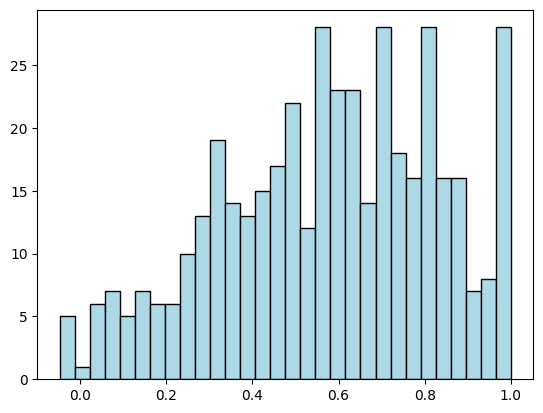

In [40]:
plt.hist(sim_scores_pos, color='lightblue', ec='black', bins=30)

(array([  1.,   6.,  32.,  49., 112., 160., 199., 238., 216., 232., 159.,
        168., 126., 108.,  80.,  65.,  37.,  49.,  41.,  26.,  16.,   9.,
         15.,   4.,   2.,   2.,   0.,   2.,   0.,   1.]),
 array([-0.15785135, -0.1252148 , -0.09257824, -0.05994168, -0.02730512,
         0.00533143,  0.03796799,  0.07060455,  0.10324111,  0.13587767,
         0.16851422,  0.20115077,  0.23378734,  0.26642388,  0.29906046,
         0.33169702,  0.36433357,  0.39697012,  0.42960668,  0.46224323,
         0.49487978,  0.52751637,  0.56015289,  0.59278947,  0.62542605,
         0.65806258,  0.69069916,  0.72333568,  0.75597227,  0.78860879,
         0.82124537]),
 <BarContainer object of 30 artists>)

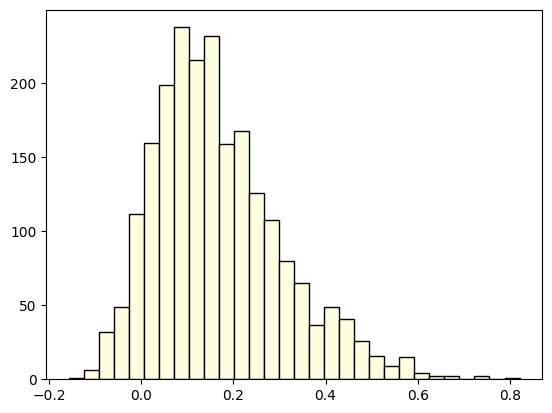

In [41]:
plt.hist(sim_scores_neg, color='lightyellow', ec='black', bins=30)

### Then compare with the similarity score if fill desc is used

In [42]:
sim_scores_pos = np.array([get_similarity_of_pair_with_desc(pair) for pair in positive_set])

In [43]:
sim_scores_neg = np.array([get_similarity_of_pair_with_desc(pair) for pair in negative_set])

In [44]:
print(sim_scores_pos.mean(), sim_scores_pos.std())
print(sim_scores_neg.mean(), sim_scores_neg.std())

0.6101277 0.21461695
0.19208175 0.12956782


(array([ 1.,  1.,  0.,  1.,  3.,  3.,  6.,  7.,  8.,  8., 10., 12., 15.,
        14., 18., 28., 26., 23., 29., 34., 24., 20., 28., 25., 18., 14.,
        16.,  5.,  8., 26.]),
 array([-0.04871121, -0.01375417,  0.02120288,  0.05615992,  0.09111696,
         0.12607402,  0.16103105,  0.1959881 ,  0.23094514,  0.26590219,
         0.30085924,  0.33581626,  0.37077332,  0.40573037,  0.44068742,
         0.47564447,  0.51060152,  0.54555857,  0.58051556,  0.61547261,
         0.65042967,  0.68538672,  0.72034377,  0.75530082,  0.79025787,
         0.82521492,  0.86017191,  0.89512897,  0.93008602,  0.96504307,
         1.00000012]),
 <BarContainer object of 30 artists>)

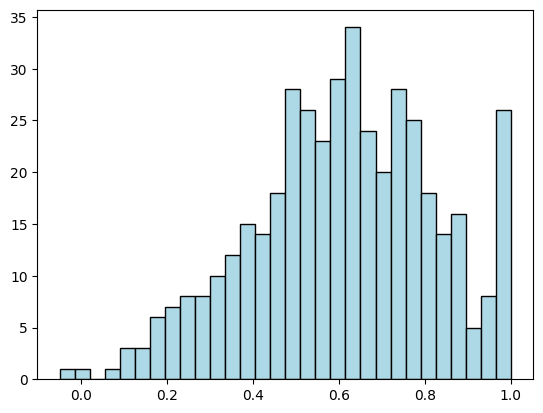

In [45]:
plt.hist(sim_scores_pos, color='lightblue', ec='black', bins=30)

(array([  1.,   2.,   3.,   8.,  32.,  84., 104., 156., 199., 247., 239.,
        223., 195., 158., 117.,  99.,  80.,  61.,  47.,  33.,  39.,  15.,
          4.,   6.,   1.,   1.,   0.,   0.,   0.,   1.]),
 array([-0.19080858, -0.15745851, -0.12410844, -0.09075837, -0.0574083 ,
        -0.02405823,  0.00929184,  0.04264191,  0.07599198,  0.10934205,
         0.14269212,  0.17604218,  0.20939226,  0.24274233,  0.27609241,
         0.30944246,  0.34279254,  0.37614262,  0.40949267,  0.44284275,
         0.47619283,  0.50954288,  0.54289293,  0.57624304,  0.60959309,
         0.64294314,  0.67629325,  0.7096433 ,  0.74299335,  0.77634346,
         0.80969352]),
 <BarContainer object of 30 artists>)

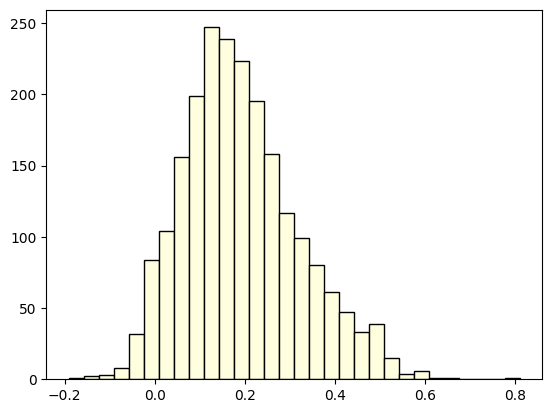

In [46]:
plt.hist(sim_scores_neg, color='lightyellow', ec='black', bins=30)

What is the percentage of pairs that has similarity score higher by comparing code features only? In other words, the natural language parts, although providing NL context to the embedding, are not as significant compared to the technical terms.

In [15]:
# for (bug_id1, bug_id2) in positive_set:
filtered_pairs_for_tables = {}

# for project_name in my_utils.table_names:
for project_name in ["spark"]:
    print(f"Processing {project_name}")
    union_find = my_utils.UnionFind()
    union_find.process_project(conn, project_name)
    
    positive_set = get_duplicated_pairs(union_find)
    # negative_set = get_non_duplicated_pairs(union_find, conn, len(positive_set)*5)
    sim_scores_pos_w_desc = np.array([get_similarity_of_pair_with_desc(conn, project_name, pair) for pair in positive_set])
    sim_scores_pos_w_tech_term = np.array([get_similarity_of_pair_with_code_feature(conn, project_name, pair) for pair in positive_set])

    filtered_pairs = []
    filtered_score_w_desc = []
    filtered_score_w_tech_term = []
    for score_w_desc, score_w_tech_term, pair in zip(tqdm(sim_scores_pos_w_desc), sim_scores_pos_w_tech_term, positive_set):
        if score_w_tech_term > score_w_desc:
            filtered_pairs += [pair,]
            filtered_score_w_desc += [score_w_desc]
            filtered_score_w_tech_term += [score_w_tech_term]
            
    filtered_pairs_for_tables[project_name] = (positive_set, filtered_pairs, filtered_score_w_desc, filtered_score_w_tech_term)
    print(len(filtered_pairs), "/", len(positive_set), f"({len(filtered_pairs)/len(positive_set)}) of table", project_name, "has higher score with code feature")

Processing spark
Processing spark


100%|██████████| 513/513 [00:00<00:00, 751284.20it/s]

194 / 513 (0.37816764132553604) of table spark has higher score with code feature


In [16]:
len(filtered_pairs) / len(positive_set)

0.37816764132553604

In [17]:
filtered_score_w_desc = filtered_pairs_for_tables["spark"][2]
filtered_score_w_tech_term = filtered_pairs_for_tables["spark"][3]

In [18]:
print(np.mean(filtered_pairs_for_tables["spark"][2]), np.mean(filtered_pairs_for_tables["spark"][3]))
print(np.std(filtered_pairs_for_tables["spark"][2]), np.std(filtered_pairs_for_tables["spark"][3]))

0.54567283 0.6195423
0.18566355 0.17498371


In [19]:
print(np.mean(np.array(filtered_score_w_tech_term) - np.array(filtered_score_w_desc)))
print(np.median(np.array(filtered_score_w_tech_term) - np.array(filtered_score_w_desc)))
print(np.max(np.array(filtered_score_w_tech_term) - np.array(filtered_score_w_desc)))
print(np.min(np.array(filtered_score_w_tech_term) - np.array(filtered_score_w_desc)))

0.07386947
0.05484709
0.3264953
1.1920929e-07


(array([28., 22., 24.,  8., 13., 15.,  9.,  8., 11.,  7.,  4.,  9.,  2.,
         9.,  3.,  8.,  0.,  4.,  3.,  1.,  1.,  0.,  0.,  0.,  0.,  1.,
         0.,  0.,  1.,  3.]),
 array([1.19209290e-07, 1.08832913e-02, 2.17664633e-02, 3.26496363e-02,
        4.35328074e-02, 5.44159822e-02, 6.52991533e-02, 7.61823282e-02,
        8.70654956e-02, 9.79486704e-02, 1.08831845e-01, 1.19715013e-01,
        1.30598187e-01, 1.41481355e-01, 1.52364537e-01, 1.63247705e-01,
        1.74130872e-01, 1.85014054e-01, 1.95897222e-01, 2.06780389e-01,
        2.17663571e-01, 2.28546739e-01, 2.39429906e-01, 2.50313073e-01,
        2.61196256e-01, 2.72079438e-01, 2.82962590e-01, 2.93845773e-01,
        3.04728955e-01, 3.15612108e-01, 3.26495290e-01]),
 <BarContainer object of 30 artists>)

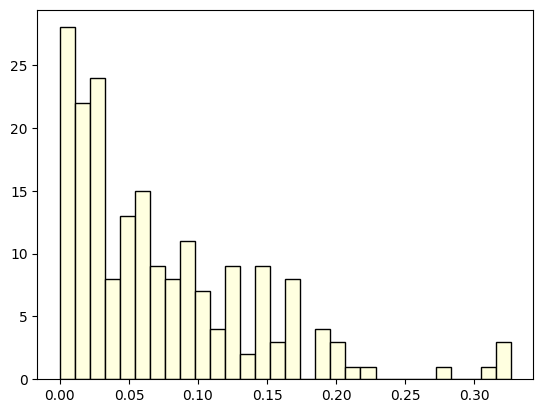

In [20]:
plt.hist(np.array(filtered_score_w_tech_term) - np.array(filtered_score_w_desc), color='lightyellow', ec='black', bins=30)

In [21]:
def get_similarity_of_pair_with_code_feature(pair):
    sent0 = get_code_feature(conn, project_name, pair[0])
    sent1 = get_code_feature(conn, project_name, pair[1])
    sent_embedding0 = model.encode(sent0,convert_to_tensor=True)
    sent_embedding1 = model.encode(sent1,convert_to_tensor=True)
    return util.pytorch_cos_sim(sent_embedding0, sent_embedding1).numpy()[0, 0]

In [22]:
def get_similarity_of_pair_with_desc(pair):
    sent0 = get_descriptions(conn, project_name, pair[0])
    sent1 = get_descriptions(conn, project_name, pair[1])
    sent_embedding0 = model.encode(sent0,convert_to_tensor=True)
    sent_embedding1 = model.encode(sent1,convert_to_tensor=True)
    return util.pytorch_cos_sim(sent_embedding0, sent_embedding1).numpy()[0, 0]

In [23]:
# index = np.argmax(np.array(filtered_score_w_tech_term) - np.array(filtered_score_w_desc))
index = 10
table = "spark"
union_find = my_utils.UnionFind()
union_find.process_project(conn, table)

bug_id1, bug_id2 = filtered_pairs_for_tables["spark"][1][index]
assert(union_find.are_dups(bug_id1, bug_id2))
score_w_desc = filtered_pairs_for_tables["spark"][2][index]
score_w_tech_term = filtered_pairs_for_tables["spark"][3][index]
print(get_similarity_of_pair_with_code_feature(conn, table, (bug_id1, bug_id2)))

tech_term1 = my_utils.get_code_feature(conn, "spark", bug_id1)
tech_term2 = my_utils.get_code_feature(conn, "spark", bug_id2)

desc1 = my_utils.get_descriptions(conn, "spark", bug_id1)
desc2 = my_utils.get_descriptions(conn, "spark", bug_id2)

print("score_w_desc", score_w_desc)
print("score_w_tech_term", score_w_tech_term)

print("\n\ntech_term1 ---------------------\n")
print(tech_term1)
print("\n\ntech_term2 ---------------------\n")
print(tech_term2)

print("\n\ndesc1 ---------------------\n")
print(desc1)
print("\n\ndesc2 ---------------------\n")
print(desc2)

# print(tech_term1, tech_term2, desc1, desc2, sep="\n\n\n------------------\n")

Processing spark


100%|██████████| 9579/9579 [00:00<00:00, 1589478.10it/s]


TypeError: get_similarity_of_pair_with_code_feature() takes 1 positional argument but 3 were given

## In a duplication recommendation system, how many times the correct duplication is included in the top 10 most similar reports?

In [14]:
table = "spark"
union_find = my_utils.UnionFind()
union_find.process_project(conn, table)

positive_set = get_duplicated_pairs(union_find)
negetive_set = get_non_duplicated_pairs(union_find, conn, len(positive_set)*5)

bug_ids = list(set([bug_id for t in positive_set for bug_id in t] + [bug_id for t in negetive_set for bug_id in t]))

vectors = []
for bug_id in tqdm(bug_ids):
    desc = my_utils.get_descriptions(conn, table, bug_id)
    ten = model.encode(desc,convert_to_tensor=True)
    vectors += [ten.detach().numpy().tolist()]

Processing spark


100%|██████████| 1242/1242 [00:48<00:00, 25.70it/s]


In [15]:
def top_closest_values_indeces(k, vectors, q):
    # Calculate the absolute differences between each element in L and v
    sim_scores = [(my_utils.similarity_score_1d(v, q), i) for i, v in enumerate(vectors)]
    # differences = [(util.pytorch_cos_sim(v, q), i) for i, v in enumerate(vectors)]

    sim_scores.sort(reverse=True)
    # print(sim_scores[:10])

    # Extract the top k closest values and their indices in the original list
    top_k_indices = [index for _, index in sim_scores[:k]]
    return top_k_indices

In [16]:
assert(len(vectors) == len(bug_ids))
for bug_id1, bug_id2 in positive_set[10:11]:
    assert(union_find.are_dups(bug_id1, bug_id2))
    
    index1 = bug_ids.index(bug_id1)
    index2 = bug_ids.index(bug_id2)
    vector1 = vectors[index1]
    topk_indeces = top_closest_values_indeces(50, np.array(vectors), np.array(vector1))
    
    if (index2 not in topk_indeces):
        print("br2 not in top")
        # id2_not_in_top_50 += 1
    else:
        print("br2 is at index", topk_indeces.index(index2))
        # id2_rank_if_in_top_50 += [topk_indeces.index(index2)]
        
    print(topk_indeces)
    print([bug_ids[i] for i in topk_indeces])
    print(bug_id1)
    print(bug_id2)
    # print(index2 in topk_indeces)
    # print(top5)
    

br2 is at index 31
[476, 588, 573, 80, 168, 479, 1066, 1129, 535, 487, 550, 700, 1229, 154, 1199, 1052, 957, 410, 802, 724, 1167, 241, 480, 40, 634, 854, 260, 1021, 1175, 523, 1116, 475, 511, 919, 1222, 701, 283, 2, 24, 372, 290, 167, 945, 1040, 485, 918, 336, 889, 1069, 308]
[13134871, 13283182, 13192953, 13165057, 13132882, 13159454, 13155149, 13229317, 13274530, 13208648, 13250046, 13193902, 13320065, 13198292, 13254305, 13327109, 13293819, 13257285, 13268249, 13169448, 13270507, 13223433, 13216799, 13205726, 13209785, 13252148, 13149828, 13179500, 13344267, 13266286, 13147349, 13134870, 13339920, 13146090, 13213523, 13316791, 13231857, 13213722, 13156462, 13232451, 13322032, 13132872, 13146271, 13138646, 13233216, 13146087, 13322388, 13195031, 13253470, 13158311]
13134871
13134870


  0%|          | 2/513 [00:00<00:30, 16.59it/s]

100%|██████████| 513/513 [00:31<00:00, 16.33it/s]


Number of id2 not in top 10: 416


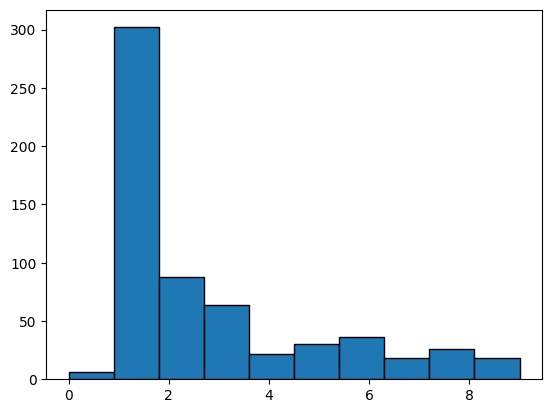

In [17]:

assert(len(vectors) == len(bug_ids))
id2_not_in_top_10 = 0
id2_rank_if_in_top_10 = []
for bug_id1, bug_id2 in tqdm(positive_set):
    assert(union_find.are_dups(bug_id1, bug_id2))
    
    index1 = bug_ids.index(bug_id1)
    index2 = bug_ids.index(bug_id2)
    vector1 = vectors[index1]
    topk_indeces = top_closest_values_indeces(10, np.array(vectors), np.array(vector1))
    
    if (index2 not in topk_indeces):
        # print("br2 not in top")
        id2_not_in_top_10 += 1
    else:
        # print("br2 is at index", topk_indeces.index(index2))
        id2_rank_if_in_top_10 += [topk_indeces.index(index2)]
        
    vector2 = vectors[index2]
    topk_indeces = top_closest_values_indeces(10, np.array(vectors), np.array(vector2))
    
    if (index1 not in topk_indeces):
        # print("br2 not in top")
        id2_not_in_top_10 += 1
    else:
        # print("br2 is at index", topk_indeces.index(index1))
        id2_rank_if_in_top_10 += [topk_indeces.index(index1)]
    # print(topk_indeces)
    # print([bug_ids[i] for i in topk_indeces])
    # print(bug_id1)
    # print(bug_id2)
    # print(index2 in topk_indeces)
    # print(top5)
    
plt.hist(np.array(id2_rank_if_in_top_10), ec='black', bins=10)
print("Number of id2 not in top 10:", id2_not_in_top_10)

    

In [19]:
print("Average ranking of bug_id2", np.array(id2_rank_if_in_top_10).mean())

Average ranking of bug_id2 2.6557377049180326


In [23]:
print("Percentage not in top:", id2_not_in_top_10/(len(positive_set)*2))

Percentage not nin top: 0.40545808966861596


Note the case of 13134871 13134870

In [29]:
print(my_utils.get_descriptions(conn, table, 13316639))



>>> spark.sparkContext.emptyRDD().toDF("col1 int").toPandas()
  An error occurred while calling o158.getResult.
: org.apache.spark.SparkException: Exception thrown in awaitResult:
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:226)
	at org.apache.spark.api.python.PythonServer.getResult(PythonRDD.scala:874)
	at org.apache.spark.api.python.PythonServer.getResult(PythonRDD.scala:870)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.ja

In [31]:
print(my_utils.get_descriptions(conn, table, 13134871))

An error occurred while calling o105.getParam. : java.util.NoSuchElementException: Param coldStartStrategy does not exist. at org.apache.spark.ml.param.Params$$anonfun$getParam$2.apply(params.scala:601) at org.apache.spark.ml.param.Params$$anonfun$getParam$2.apply(params.scala:601) at scala.Option.getOrElse(Option.scala:121) at org.apache.spark.ml.param.Params$class.getParam(params.scala:600) at org.apache.spark.ml.PipelineStage.getParam(Pipeline.scala:42) at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method) at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:57) at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43) at java.lang.reflect.Method.invoke(Method.java:606) at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244) at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357) at py4j.Gateway.invoke(Gateway.java:280) at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132) at py4j

In [30]:
union_find.are_dups(13134871, 13316639)

False

## Stacktrace might be the cause of high similarity among the reports, we subtract out the stacktrace from each report and try again

In [14]:
database_path = "./dbrd_processed.db"


conn = sqlite3.connect(database_path)
cursor = conn.cursor()

### Eclipse desc with stacktrace

In [97]:
table = "eclipse"
union_find = my_utils.UnionFind()
union_find.process_project(conn, table, min_desc_length=10)

positive_set = get_duplicated_pairs(union_find)
negetive_set = get_non_duplicated_pairs(union_find, conn, len(positive_set)*5)

bug_ids = list(set([bug_id for t in positive_set for bug_id in t] + [bug_id for t in negetive_set for bug_id in t]))

vectors = []
for bug_id in tqdm(bug_ids):
    desc = my_utils.get_descriptions(conn, table, bug_id)
    ten = model.encode(desc,convert_to_tensor=True)
    vectors += [ten.detach().numpy().tolist()]

Processing eclipse


100%|██████████| 2394/2394 [01:06<00:00, 36.17it/s]


In [98]:

assert(len(vectors) == len(bug_ids))
dup_in_top_k_count = 0
total_count = 0
dup_in_top_k_indeces = []
for bug_id1, bug_id2 in tqdm(positive_set):
    assert(union_find.are_dups(bug_id1, bug_id2))
    
    index1 = bug_ids.index(bug_id1)
    index2 = bug_ids.index(bug_id2)
    vector1 = vectors[index1]
    vector2 = vectors[index2]
    topk_indeces, sim_scores = top_closest_values_indeces(11, np.array(vectors), np.array(vector1))
    
    # if (index2 not in topk_indeces):
        # print("br2 not in top")
        # id2_not_in_top_10 += 1
    # else:
        # print("br2 is at index", topk_indeces.index(index2))
        # id2_rank_if_in_top_10 += [topk_indeces.index(index2)]
        
    # print(sim_scores)
    # print(topk_indeces)
    topk = [bug_ids[i] for i in topk_indeces]
    # print(topk)
    dup_in_top_k = False
    for top_bug_id in topk:
        if union_find.are_dups(bug_id1, top_bug_id) and bug_id1 != top_bug_id:
            dup_in_top_k_count += 1
            dup_in_top_k_indeces += [topk.index(top_bug_id)]
            dup_in_top_k = True
            break
    total_count += 1
    # print(dup_in_top_k)
        
    topk_indeces, sim_scores = top_closest_values_indeces(11, np.array(vectors), np.array(vector2))
    
    # if (index1 not in topk_indeces):
        # print("br1 not in top")
        # id2_not_in_top_10 += 1
    # else:
        # print("br1 is at index", topk_indeces.index(index1))
        # id2_rank_if_in_top_10 += [topk_indeces.index(index1)]
        
    # print(sim_scores)
    # print(topk_indeces)
    
    topk = [bug_ids[i] for i in topk_indeces]
    # print(topk)
    dup_in_top_k = False
    for top_bug_id in topk:
        if union_find.are_dups(bug_id2, top_bug_id) and bug_id2 != top_bug_id:
            dup_in_top_k_count += 1
            dup_in_top_k_indeces += [topk.index(top_bug_id)]
            dup_in_top_k = True
            break
    total_count += 1
    # print(dup_in_top_k)
    # print(bug_id1)
    # print(bug_id2)
    # print(index2 in topk_indeces)

100%|██████████| 1510/1510 [03:22<00:00,  7.47it/s]


In [99]:
dup_in_top_k_count

2581

In [100]:
total_count

3020

In [101]:
dup_in_top_k_count/total_count

0.854635761589404

### Eclipse desc  without stacktrace 

In [102]:
table = "eclipse"
union_find = my_utils.UnionFind()
union_find.process_project(conn, table, min_desc_length=10)

positive_set = get_duplicated_pairs(union_find)
negetive_set = get_non_duplicated_pairs(union_find, conn, len(positive_set)*5)

bug_ids = list(set([bug_id for t in positive_set for bug_id in t] + [bug_id for t in negetive_set for bug_id in t]))

vectors = []
for bug_id in tqdm(bug_ids):
    desc = my_utils.get_desc_wo_stacktrace(conn, table, bug_id)
    ten = model.encode(desc,convert_to_tensor=True)
    vectors += [ten.detach().numpy().tolist()]

Processing eclipse


  0%|          | 0/27583 [00:00<?, ?it/s]

100%|██████████| 2394/2394 [01:02<00:00, 38.13it/s]


In [103]:
def top_closest_values_indeces(k, vectors, q):
    # Calculate the absolute differences between each element in L and v
    sim_scores = [(my_utils.similarity_score_1d(v, q), i) for i, v in enumerate(vectors)]
    # differences = [(util.pytorch_cos_sim(v, q), i) for i, v in enumerate(vectors)]

    sim_scores.sort(reverse=True)
    # print(sim_scores[:10])

    # Extract the top k closest values and their indices in the original list
    top_k_indices = [index for _, index in sim_scores[:k]]
    return top_k_indices, sim_scores

100%|██████████| 1510/1510 [03:38<00:00,  6.91it/s]


Number of id2 not in top 10: 1339


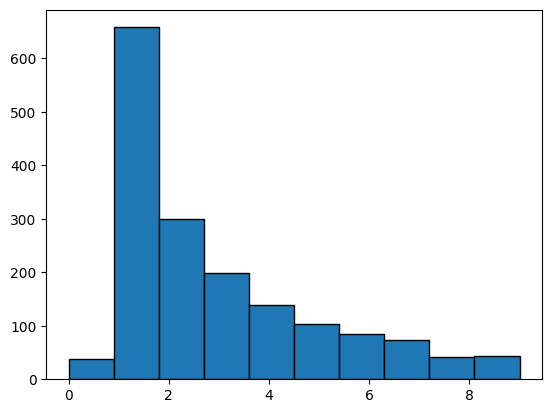

In [46]:

assert(len(vectors) == len(bug_ids))
id2_not_in_top_10 = 0
id2_rank_if_in_top_10 = []
for bug_id1, bug_id2 in tqdm(positive_set):
    assert(union_find.are_dups(bug_id1, bug_id2))
    
    index1 = bug_ids.index(bug_id1)
    index2 = bug_ids.index(bug_id2)
    vector1 = vectors[index1]
    vector2 = vectors[index2]
    topk_indeces, _ = top_closest_values_indeces(10, np.array(vectors), np.array(vector1))
    
    if (index2 not in topk_indeces):
        # print("br2 not in top")
        id2_not_in_top_10 += 1
    else:
        # print("br2 is at index", topk_indeces.index(index2))
        id2_rank_if_in_top_10 += [topk_indeces.index(index2)]
        
    topk_indeces, _ = top_closest_values_indeces(10, np.array(vectors), np.array(vector2))
    
    if (index1 not in topk_indeces):
        # print("br2 not in top")
        id2_not_in_top_10 += 1
    else:
        # print("br2 is at index", topk_indeces.index(index1))
        id2_rank_if_in_top_10 += [topk_indeces.index(index1)]
        
    # print(topk_indeces)
    # print([bug_ids[i] for i in topk_indeces])
    # print(bug_id1)
    # print(bug_id2)
    # print(index2 in topk_indeces)
    # print(top5)
    
plt.hist(np.array(id2_rank_if_in_top_10), ec='black', bins=10)
print("Number of id2 not in top 10:", id2_not_in_top_10)

In [47]:
print("Percentage not in top:", id2_not_in_top_10/(len(positive_set)*2))

Percentage not in top: 0.4433774834437086


In [48]:
print("Average ranking of bug_id2", np.array(id2_rank_if_in_top_10).mean())

Average ranking of bug_id2 2.7840571088637716


In [104]:

assert(len(vectors) == len(bug_ids))
dup_in_top_k_count = 0
total_count = 0
dup_in_top_k_indeces = []
for bug_id1, bug_id2 in tqdm(positive_set):
    assert(union_find.are_dups(bug_id1, bug_id2))
    
    index1 = bug_ids.index(bug_id1)
    index2 = bug_ids.index(bug_id2)
    vector1 = vectors[index1]
    vector2 = vectors[index2]
    topk_indeces, sim_scores = top_closest_values_indeces(11, np.array(vectors), np.array(vector1))
    
    # if (index2 not in topk_indeces):
        # print("br2 not in top")
        # id2_not_in_top_10 += 1
    # else:
        # print("br2 is at index", topk_indeces.index(index2))
        # id2_rank_if_in_top_10 += [topk_indeces.index(index2)]
        
    # print(sim_scores)
    # print(topk_indeces)
    topk = [bug_ids[i] for i in topk_indeces]
    # print(topk)
    dup_in_top_k = False
    for top_bug_id in topk:
        if union_find.are_dups(bug_id1, top_bug_id) and bug_id1 != top_bug_id:
            dup_in_top_k_count += 1
            dup_in_top_k_indeces += [topk.index(top_bug_id)]
            dup_in_top_k = True
            break
    total_count += 1
    # print(dup_in_top_k)
        
    topk_indeces, sim_scores = top_closest_values_indeces(11, np.array(vectors), np.array(vector2))
    
    # if (index1 not in topk_indeces):
        # print("br1 not in top")
        # id2_not_in_top_10 += 1
    # else:
        # print("br1 is at index", topk_indeces.index(index1))
        # id2_rank_if_in_top_10 += [topk_indeces.index(index1)]
        
    # print(sim_scores)
    # print(topk_indeces)
    
    topk = [bug_ids[i] for i in topk_indeces]
    # print(topk)
    dup_in_top_k = False
    for top_bug_id in topk:
        if union_find.are_dups(bug_id2, top_bug_id) and bug_id2 != top_bug_id:
            dup_in_top_k_count += 1
            dup_in_top_k_indeces += [topk.index(top_bug_id)]
            dup_in_top_k = True
            break
    total_count += 1
    # print(dup_in_top_k)
    # print(bug_id1)
    # print(bug_id2)
    # print(index2 in topk_indeces)

  0%|          | 0/1510 [00:00<?, ?it/s]

100%|██████████| 1510/1510 [03:20<00:00,  7.54it/s]


In [105]:
dup_in_top_k_count

2672

In [106]:
total_count

3020

In [108]:
dup_in_top_k_count/total_count

0.8847682119205298

In [26]:
print(my_utils.get_desc_wo_stacktrace(conn, table, 563220))
print(my_utils.get_stacktrace(conn, table, 563220))

Eclipse 2020-03 hangs after choosing the workspace Eclipse 2020-03 hangs after choosing the workspaceCreated attachment 282870Full thread dumpAll,I've just installed Eclipse 2020-03 C developers version. When I run it - after selecting the workspace - it hangs.The debugging console shows:---osgi> log4j:WARN No appenders could be found for logger (org.eclipse.jgit.internal.storage.file.FileSnapshot).log4j:WARN Please initialize the log4j system properly.---I attach the thread dump.Any idea of what's happening?Regards,  Rosario



In [27]:
print(my_utils.get_desc_wo_stacktrace(conn, table, 565285))
print(my_utils.get_stacktrace(conn, table, 565285))

Cannot run Eclipse IDE 2020 after installing WSL 2 Cannot run Eclipse IDE 2020 after installing WSL 2Created attachment 283629WSL 2 processes running under eclipse.exeSee https://github.com/microsoft/WSL/issues/5599Some weeks ago I installed WSL 2 on Windows 10.It was working (was able to use "Ubuntu 20.04 LTS" virtual machine).Eclipse was also working.After Windows restart (due to Windows Update), Eclipse IDE 2020-06 got stuck in the middle of startup. It has nothing to do with workspace, because even new workspace could not be started.Eclipse IDE 2019 could be started without problems.I opened Task Manager and noticed under eclipse.exe there were some processes for WSL 2.There are 2 workarounds:Workaround 1:Call this in PowerShell:wsl --shutdownEclipse startup will continueWorkaround 2:Open "Ubuntu 20.04 LTS" before starting Eclipse.In this case Task Manager shows WSL 2 processes running under "Ubuntu 20.04 LTS" instead of "eclipse.exe"



In [55]:
print(my_utils.get_desc_wo_stacktrace(conn, table, 535608))
print(my_utils.get_stacktrace(conn, table, 535608))

Eclipse freeze several times in a day work Eclipse freeze several times in a day workAfter some hours of work I've notice a lots of UI monitor logs (UI freeze):most of them are shorts (less than a seconds)some of them are long greater than 10 secone was of 96 seconds...the positive things is that eclipse has never needed a restart.I'm sending you the full logs for the freezes (I hope this could help to get eclipse betrer and better)Running on  a ubuntu 16.04puginCDTPDTJSDTMYLYNTM with RSE-- Configuration Details --Product: Eclipse IDE 4.8.0.20180531-0839 (org.eclipse.epp.package.cpp.product)Installed Features: org.eclipse.platform 4.8.0.v20180524-1240



In [52]:
print(my_utils.get_desc_wo_stacktrace(conn, table, 560891))
print(my_utils.get_stacktrace(conn, table, 560891))

Eclipse forced termination status report Eclipse forced termination status reportCreated attachment 282043Eclipse forced termination status reportAfter plug-in installation and eclipse, loading to the workspace is completed, and suddenly the program is forced to end. I will upload the log file. Please analyze it.



In [56]:
print(my_utils.get_desc_wo_stacktrace(conn, table, 551947))
print(my_utils.get_stacktrace(conn, table, 551947))

Eclipse 2019-09 Core-dumps occasionally Eclipse 2019-09 Core-dumps occasionallyCreated attachment 280208Java 8 - core-dump fileI can consistently reproduce this in Eclipse Java (Oomph) installation on Windows and also in runtime workbench with RCP installation. It only applies to september 2019 release, not to june release.I do not have any useful stacks.## A fatal error has been detected by the Java Runtime Environment:##  EXCEPTION_ACCESS_VIOLATION (0xc0000005) at pc=0x00007ff945295edc, pid=16660, tid=0x0000000000000ec0## JRE version: Java(TM) SE Runtime Environment (8.0_161-b12) (build 1.8.0_161-b12)# Java VM: Java HotSpot(TM) 64-Bit Server VM (25.161-b12 mixed mode windows-amd64 compressed oops)# Problematic frame:# C  [oleacc.dll+0x5edc]## Failed to write core dump. Minidumps are not enabled by default on client versions of Windows## An error report file with more information is saved as:# C:\eclipse\e201909rcp\eclipse\hs_err_pid16660.log## If you would like to submit a bug report

### Spark desc with stacktrace

In [78]:
table = "spark"
union_find = my_utils.UnionFind()
union_find.process_project(conn, table, min_desc_length=10)

positive_set = get_duplicated_pairs(union_find)
negetive_set = get_non_duplicated_pairs(union_find, conn, len(positive_set)*5)

bug_ids = list(set([bug_id for t in positive_set for bug_id in t] + [bug_id for t in negetive_set for bug_id in t]))

vectors = []
for bug_id in tqdm(bug_ids):
    desc = my_utils.get_descriptions(conn, table, bug_id)
    ten = model.encode(desc,convert_to_tensor=True)
    vectors += [ten.detach().numpy().tolist()]

Processing spark


100%|██████████| 795/795 [00:24<00:00, 32.40it/s]


In [79]:
def top_closest_values_indeces(k, vectors, q):
    # Calculate the absolute differences between each element in L and v
    sim_scores = [(my_utils.similarity_score_1d(v, q), i) for i, v in enumerate(vectors)]
    # differences = [(util.pytorch_cos_sim(v, q), i) for i, v in enumerate(vectors)]

    sim_scores.sort(reverse=True)
    # print(sim_scores[:10])

    # Extract the top k closest values and their indices in the original list
    top_k_indices = [index for _, index in sim_scores[:k]]
    return top_k_indices, sim_scores

In [81]:

assert(len(vectors) == len(bug_ids))
dup_in_top_k_count = 0
total_count = 0
dup_in_top_k_indeces = []
for bug_id1, bug_id2 in tqdm(positive_set):
    assert(union_find.are_dups(bug_id1, bug_id2))
    
    index1 = bug_ids.index(bug_id1)
    index2 = bug_ids.index(bug_id2)
    vector1 = vectors[index1]
    vector2 = vectors[index2]
    topk_indeces, sim_scores = top_closest_values_indeces(10, np.array(vectors), np.array(vector1))
    
    # if (index2 not in topk_indeces):
        # print("br2 not in top")
        # id2_not_in_top_10 += 1
    # else:
        # print("br2 is at index", topk_indeces.index(index2))
        # id2_rank_if_in_top_10 += [topk_indeces.index(index2)]
        
    # print(sim_scores)
    # print(topk_indeces)
    topk = [bug_ids[i] for i in topk_indeces]
    # print(topk)
    dup_in_top_k = False
    for top_bug_id in topk:
        if union_find.are_dups(bug_id1, top_bug_id) and bug_id1 != top_bug_id:
            dup_in_top_k_count += 1
            dup_in_top_k_indeces += [topk.index(top_bug_id)]
            dup_in_top_k = True
            break
    total_count += 1
    # print(dup_in_top_k)
        
    topk_indeces, sim_scores = top_closest_values_indeces(10, np.array(vectors), np.array(vector2))
    
    # if (index1 not in topk_indeces):
        # print("br1 not in top")
        # id2_not_in_top_10 += 1
    # else:
        # print("br1 is at index", topk_indeces.index(index1))
        # id2_rank_if_in_top_10 += [topk_indeces.index(index1)]
        
    # print(sim_scores)
    # print(topk_indeces)
    
    topk = [bug_ids[i] for i in topk_indeces]
    # print(topk)
    dup_in_top_k = False
    for top_bug_id in topk:
        if union_find.are_dups(bug_id2, top_bug_id) and bug_id2 != top_bug_id:
            dup_in_top_k_count += 1
            dup_in_top_k_indeces += [topk.index(top_bug_id)]
            dup_in_top_k = True
            break
    total_count += 1
    # print(dup_in_top_k)
    # print(bug_id1)
    # print(bug_id2)
    # print(index2 in topk_indeces)

  0%|          | 0/341 [00:00<?, ?it/s]

100%|██████████| 341/341 [00:17<00:00, 19.92it/s]


In [82]:
dup_in_top_k_count

574

In [83]:
total_count

682

In [84]:
dup_in_top_k_count/total_count

0.841642228739003

### Spark desc without stacktrace

In [85]:
table = "spark"
union_find = my_utils.UnionFind()
union_find.process_project(conn, table, min_desc_length=10)

positive_set = get_duplicated_pairs(union_find)
negetive_set = get_non_duplicated_pairs(union_find, conn, len(positive_set)*5)

bug_ids = list(set([bug_id for t in positive_set for bug_id in t] + [bug_id for t in negetive_set for bug_id in t]))

vectors = []
for bug_id in tqdm(bug_ids):
    desc = my_utils.get_desc_wo_stacktrace(conn, table, bug_id)
    ten = model.encode(desc,convert_to_tensor=True)
    vectors += [ten.detach().numpy().tolist()]

Processing spark


100%|██████████| 799/799 [00:23<00:00, 33.50it/s]


  0%|          | 0/341 [00:00<?, ?it/s]

100%|██████████| 341/341 [00:15<00:00, 21.77it/s]


Number of id2 not in top 10: 184


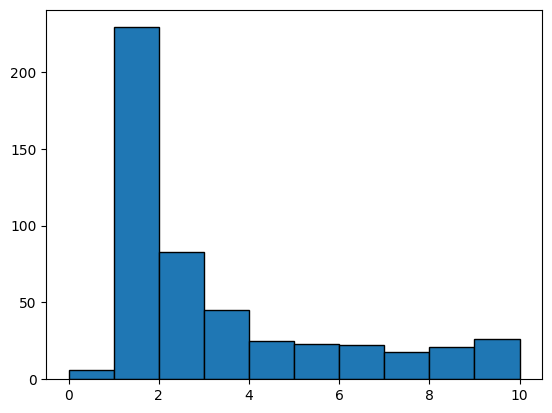

In [86]:

assert(len(vectors) == len(bug_ids))
id2_not_in_top_10 = 0
id2_rank_if_in_top_10 = []
for bug_id1, bug_id2 in tqdm(positive_set):
    assert(union_find.are_dups(bug_id1, bug_id2))
    
    index1 = bug_ids.index(bug_id1)
    index2 = bug_ids.index(bug_id2)
    vector1 = vectors[index1]
    vector2 = vectors[index2]
    topk_indeces, _ = top_closest_values_indeces(11, np.array(vectors), np.array(vector1))
    
    if (index2 not in topk_indeces):
        # print("br2 not in top")
        id2_not_in_top_10 += 1
    else:
        # print("br2 is at index", topk_indeces.index(index2))
        id2_rank_if_in_top_10 += [topk_indeces.index(index2)]
        
    topk_indeces, _ = top_closest_values_indeces(11, np.array(vectors), np.array(vector2))
    
    if (index1 not in topk_indeces):
        # print("br2 not in top")
        id2_not_in_top_10 += 1
    else:
        # print("br2 is at index", topk_indeces.index(index1))
        id2_rank_if_in_top_10 += [topk_indeces.index(index1)]
        
    # print(topk_indeces)
    # print([bug_ids[i] for i in topk_indeces])
    # print(bug_id1)
    # print(bug_id2)
    # print(index2 in topk_indeces)
    # print(top5)
    
plt.hist(np.array(id2_rank_if_in_top_10), ec='black', bins=10)
print("Number of id2 not in top 10:", id2_not_in_top_10)

In [87]:
print("Percentage not in top:", id2_not_in_top_10/(len(positive_set)*2))

Percentage not in top: 0.2697947214076246


In [88]:
print("Average ranking of bug_id2", np.array(id2_rank_if_in_top_10).mean())

Average ranking of bug_id2 2.8493975903614457


In [93]:

assert(len(vectors) == len(bug_ids))
dup_in_top_k_count = 0
total_count = 0
dup_in_top_k_indeces = []
for bug_id1, bug_id2 in tqdm(positive_set):
    assert(union_find.are_dups(bug_id1, bug_id2))
    
    index1 = bug_ids.index(bug_id1)
    index2 = bug_ids.index(bug_id2)
    vector1 = vectors[index1]
    vector2 = vectors[index2]
    topk_indeces, sim_scores = top_closest_values_indeces(11, np.array(vectors), np.array(vector1))
    
    # if (index2 not in topk_indeces):
        # print("br2 not in top")
        # id2_not_in_top_10 += 1
    # else:
        # print("br2 is at index", topk_indeces.index(index2))
        # id2_rank_if_in_top_10 += [topk_indeces.index(index2)]
        
    # print(sim_scores)
    # print(topk_indeces)
    topk = [bug_ids[i] for i in topk_indeces]
    # print(topk)
    dup_in_top_k = False
    for top_bug_id in topk:
        if union_find.are_dups(bug_id1, top_bug_id) and bug_id1 != top_bug_id:
            dup_in_top_k_count += 1
            dup_in_top_k_indeces += [topk.index(top_bug_id)]
            dup_in_top_k = True
            break
    total_count += 1
    # print(dup_in_top_k)
        
    topk_indeces, sim_scores = top_closest_values_indeces(11, np.array(vectors), np.array(vector2))
    
    # if (index1 not in topk_indeces):
        # print("br1 not in top")
        # id2_not_in_top_10 += 1
    # else:
        # print("br1 is at index", topk_indeces.index(index1))
        # id2_rank_if_in_top_10 += [topk_indeces.index(index1)]
        
    # print(sim_scores)
    # print(topk_indeces)
    
    topk = [bug_ids[i] for i in topk_indeces]
    # print(topk)
    dup_in_top_k = False
    for top_bug_id in topk:
        if union_find.are_dups(bug_id2, top_bug_id) and bug_id2 != top_bug_id:
            dup_in_top_k_count += 1
            dup_in_top_k_indeces += [topk.index(top_bug_id)]
            dup_in_top_k = True
            break
    total_count += 1
    # print(dup_in_top_k)
    # print(bug_id1)
    # print(bug_id2)
    # print(index2 in topk_indeces)

  0%|          | 0/341 [00:00<?, ?it/s]

100%|██████████| 341/341 [00:17<00:00, 19.05it/s]


In [94]:
dup_in_top_k_count

608

In [95]:
total_count

682

In [96]:
dup_in_top_k_count/total_count

0.8914956011730205

### Extracting stacktrace helps improving the ranking of duplicated bug reports

### What are the other characteristics that affect the efficient ranking of bug reports

In [48]:
assert(len(vectors) == len(bug_ids))
index = 11
for bug_id1, bug_id2 in positive_set[index:index+1]:
    assert(union_find.are_dups(bug_id1, bug_id2))
    
    index1 = bug_ids.index(bug_id1)
    index2 = bug_ids.index(bug_id2)
    vector1 = vectors[index1]
    topk_indeces = top_closest_values_indeces(50, np.array(vectors), np.array(vector1))
    
    if (index2 not in topk_indeces):
        print("br2 not in top")
    else:
        print("br2 is at index", topk_indeces.index(index2))
        
    print(topk_indeces)
    print([bug_ids[i] for i in topk_indeces])
    print(bug_id1)
    print(bug_id2)
    # print(index2 in topk_indeces)
    # print(top5)

br2 is at index 7
[1080, 374, 1121, 454, 598, 390, 544, 797, 841, 597, 616, 170, 794, 795, 844, 916, 763, 1153, 53, 252, 728, 768, 214, 438, 639, 76, 884, 720, 971, 473, 285, 903, 902, 428, 394, 111, 569, 10, 240, 837, 1243, 373, 1001, 514, 378, 871, 472, 183, 264, 729]
[13253656, 13257083, 13278480, 13265758, 13283214, 13167101, 13323696, 13243660, 13227504, 13283213, 13275162, 13264036, 13341955, 13260042, 13293049, 13170657, 13325380, 13245899, 13287805, 13346504, 13243221, 13243496, 13223319, 13232914, 13201616, 13320781, 13219569, 13259547, 13130094, 13347832, 13207386, 13244288, 13244287, 13257445, 13322772, 13189885, 13143707, 13156462, 13182573, 13194719, 13262809, 13207928, 13179431, 13290748, 13158822, 13293226, 13151215, 13223141, 13231857, 13194072]
13253656
13243660


In [49]:
print(my_utils.get_desc_wo_stacktrace(conn, table, 13253656))
print(my_utils.get_stacktrace(conn, table, 13253656))

ANSI SQL: delete and update does not support in Spark ANSI SQL: delete and update does not support in Sparkdelete and update supported in PostgresSQLcreate table emp_test(id int);insert into emp_test values(100);insert into emp_test values(200);select * from emp_test;delete from emp_test where id=100;select * from emp_test;update emp_test set id=500 where id=200;select * from emp_test;



In [50]:
print(my_utils.get_desc_wo_stacktrace(conn, table, 13257083))
print(my_utils.get_stacktrace(conn, table, 13257083))

DEFAULT option is not supported in Spark DEFAULT option is not supported in SparkPostgreSQL supports default option as below**CREATE TABLE update_test ( a INT DEFAULT 10, b INT);INSERT INTO update_test VALUES (5, 10);INSERT INTO update_test(b) VALUES (15);SELECT * FROM update_test;



In [33]:
print(my_utils.get_desc_wo_stacktrace(conn, table, 13254983))
print(my_utils.get_stacktrace(conn, table, 13254983))

Document working of Adaptive Document working of Adaptivespark submit --conf spark.lineage.enabled参数是什么意思啊，查了官网，网上，都没有搜到。。配置这个参数有什么益处



# EOF